# Visualisation for Random Forest Attack

In [16]:
import multiprocessing
import time

from graphviz import Source
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import export_graphviz
from tqdm import trange

from rfa import RandomForestAttack

In [2]:
SEED = 0

In [3]:
X, y = make_blobs(n_samples=300, n_features=2, centers=4,
                  random_state=SEED, cluster_std=1.0)
# Rescaling to [-1, 1]
X_max = np.max(X, axis=0)
X_min = np.min(X, axis=0)
X = 1 - 2 * (X - X_min)/(X_max - X_min)

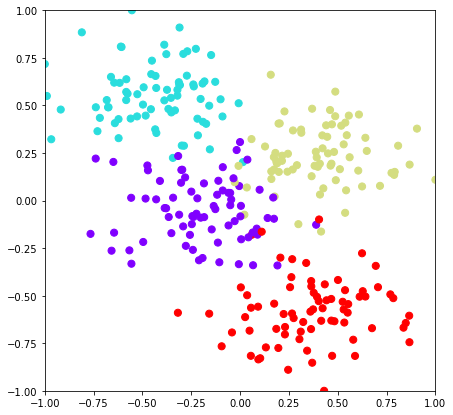

In [4]:
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

In [5]:
def visualize_classifier(model, X, y, cmap='rainbow'):
    plt.figure(figsize=(7, 7))
    ax = plt.gca()
    
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap, 
               clim=(y.min(), y.max()), zorder=3)
    xlim = (-1.0, 1.0)
    ylim = (-1.0, 1.0)
    
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    plt.show()

In [6]:
N_TREES = 10
model = RandomForestClassifier(n_estimators=N_TREES, random_state=SEED)
model.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

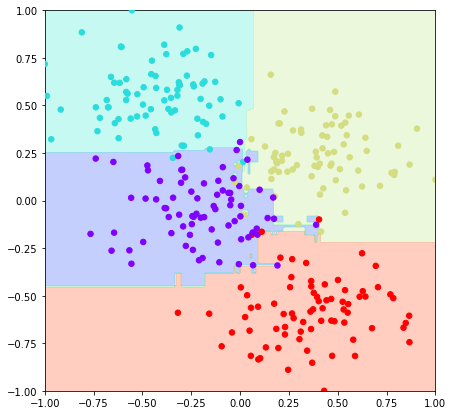

In [7]:
visualize_classifier(model, X, y)

In [8]:
digraphs = []

for estimator in model.estimators_:
    dot = export_graphviz(estimator,
                feature_names = ['x0', 'x1'],
                class_names = ['0', '1', '2', '3'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)
    digraphs.append(Source(dot))

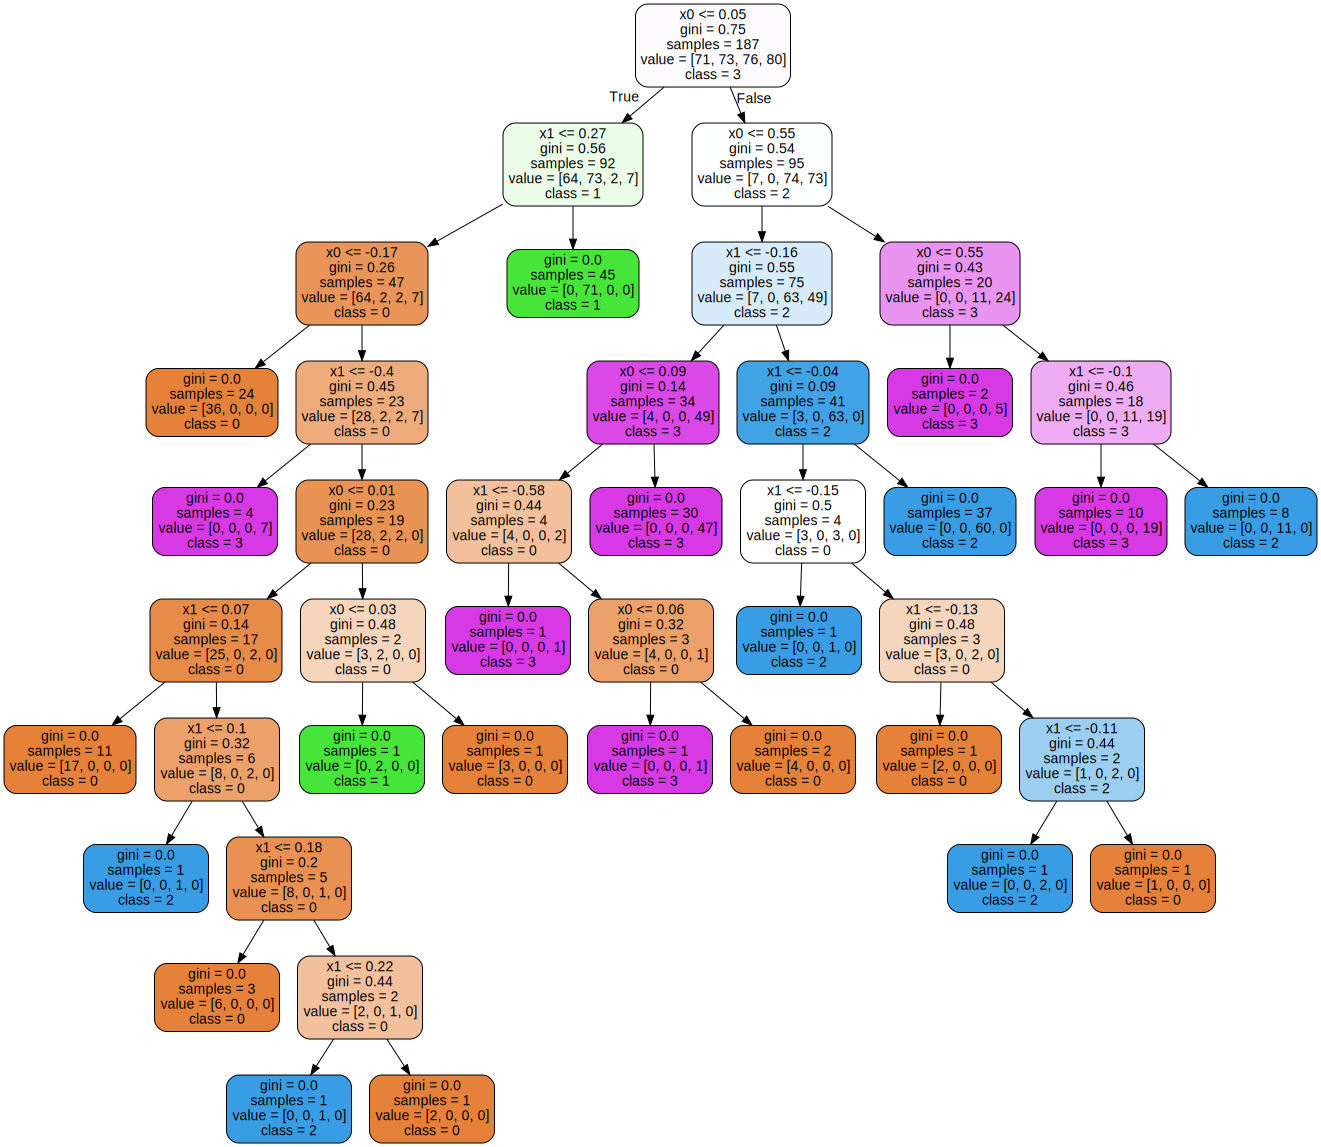

In [9]:
digraphs[0]

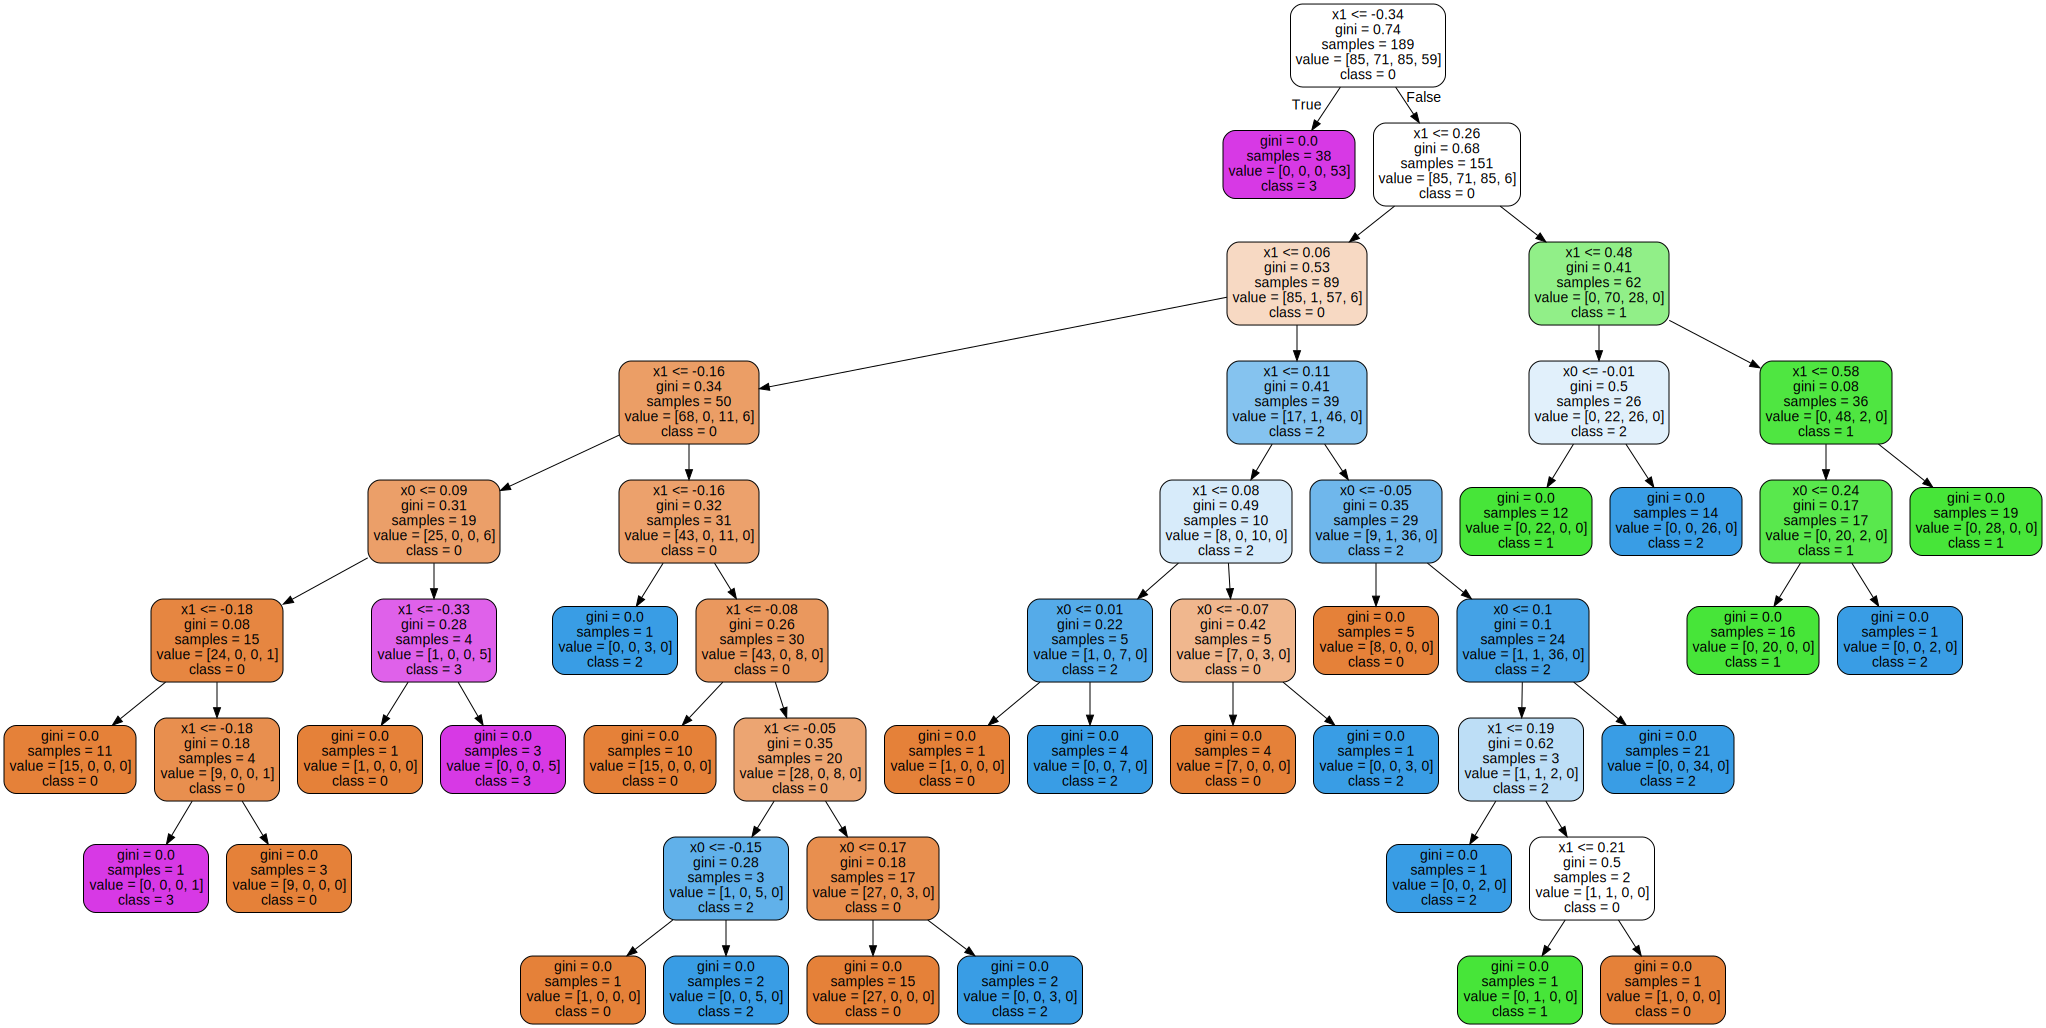

In [10]:
digraphs[1]

In [11]:
print('Accuracy on train set:', model.score(X, y))

Accuracy on train set: 0.9966666666666667


In [17]:
# Hyperparameters
N_THREADS = multiprocessing.cpu_count()
EPSILON = 1e-4  # The minimum change to update a feature.
MAX_BUDGET = 0.1 * X.shape[1]   # The max. perturbation is allowed.
SIZE = 100

In [18]:
shuffled_indices = np.random.choice(X.shape[0], size=SIZE, replace=False)
X_test = X[shuffled_indices]
y_test = y[shuffled_indices]
print('Accuracy on test set: {:.2f}%'.format(model.score(X_test, y_test) * 100))

Accuracy on test set: 100.00%


In [20]:
attack = RandomForestAttack(model, max_budget=MAX_BUDGET, epsilon=EPSILON,
                            rule='least_leaf', n_threads=N_THREADS)

In [21]:
start = time.time()
X_adv = attack.generate(X_test, y_test)
time_elapsed = time.time() - start
print('Time to complete: {:d}m {:.3f}s'.format(int(time_elapsed // 60), time_elapsed % 60))

String the   10th data point...
String the   20th data point...
String the   30th data point...
String the   40th data point...
String the   50th data point...
String the   60th data point...
String the   70th data point...
String the   80th data point...
String the   90th data point...
String the  100th data point...
Time to complete: 0m 7.706s


In [22]:
y_pred = model.predict(X_test)
acc = np.count_nonzero(y_pred == y_test) / SIZE
print('Accuracy on test set = {:.2f}%'.format(acc*SIZE))

adv_pred = model.predict(X_adv)
acc = np.count_nonzero(adv_pred == y_test) / SIZE
print('Accuracy on adversarial example set = {:.2f}%'.format(acc*SIZE))

Accuracy on test set = 100.00%
Accuracy on adversarial example set = 0.00%


In [23]:
l2_norm = np.mean(np.linalg.norm(X_test - X_adv, axis=1))
print('Average l2 norm = {:.3f}'.format(l2_norm))

Average l2 norm = 0.255


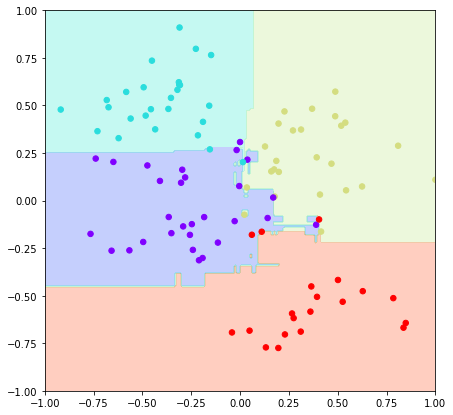

In [24]:
visualize_classifier(model, X[shuffled_indices], y[shuffled_indices])

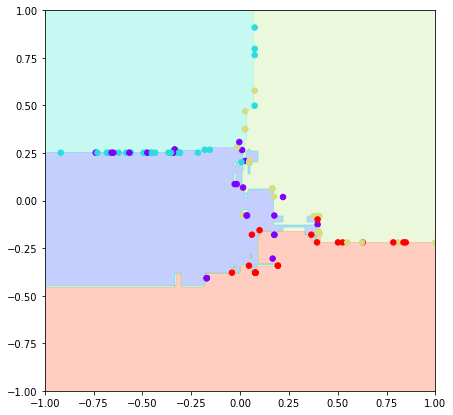

In [25]:
visualize_classifier(model, X_adv, y[shuffled_indices])